# Testing DEMV on Park Datset

- Positive Label: `score_cut=0`
- Protected group: males with more than 65 years (`age = 1 && sex = 0`)

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

from utils import *
from demv import DEMV

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def prepare_data():
  data = pd.read_csv('data2/park.csv')
  data.drop(['subject#', 'a', 'y', 'yhat', 'motor_UPDRS', 'total_UPDRS', 'test_time'], axis=1, inplace=True)
  data.loc[data['age']<65, 'age'] = 0
  data.loc[data['age']>=65, 'age'] = 1
  data['score_cut'].replace({
    'Mild': 0,
    'Moderate': 1,
    'Severe': 2
  }, inplace=True)
  changed_labels = data[(data['age']==1)&(data['sex']==1)&(data['score_cut']==1)].sample(n=200).index
  data.loc[changed_labels, 'score_cut'] = 0
  return data

In [17]:
data = prepare_data()
data

,age,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,score_cut
0,1,0,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,1
1,1,0,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,1
2,1,0,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,1
3,1,0,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,1
4,1,0,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,0,0,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,1
5871,0,0,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,1
5872,0,0,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,1
5873,0,0,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,1


In [18]:
label = 'score_cut'
sensitive_vars = ['age', 'sex']
protected_group = {'age': 1, 'sex': 0}
positive_label = 0

In [19]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased classifier

In [20]:
model, metrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [21]:
print_metrics(metrics)

Statistical parity:  -0.205  +-  0.041
Disparate impact:  0.441  +-  0.095
Zero one loss:  0.223  +-  0.063
F1 score:  0.47  +-  0.03
Accuracy score:  0.507  +-  0.025


## DEMV application

In [22]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [23]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_vars, positive_label, debiaser=demv)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [24]:
print_metrics(demv_metrics)

Statistical parity:  -0.064  +-  0.05
Disparate impact:  0.804  +-  0.137
Zero one loss:  0.217  +-  0.04
F1 score:  0.432  +-  0.024
Accuracy score:  0.494  +-  0.021


## DEMV Evaluation

In [25]:
demv.get_iters()

179

In [26]:
180/34

5.294117647058823

In [27]:
metrics = eval_demv(34, 180, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [28]:
sensitive_features = ['combined']
unpriv_group = {'combined': 1}

In [29]:
data.loc[:,"combined"] = 0
data.loc[(data['age'] == 1) & (data["sex"] == 0),"combined"] = 1

In [30]:
#Now pred contains the actual values on column "y_true" and predicted values on column "contr_use"

pred.loc[:,"combined"] = 0
pred.loc[(pred['age'] == 1) & (pred["sex"] == 0),"combined"] = 1

In [31]:
y_pred = pred[label].values
y_true = pred['y_true'].values

In [32]:
import tools
stats = tools.clf_metrics(y_true, y_pred)
stats

,tp,fp,tn,fn,sens,spec,ppv,npv,j,f1,mcc,brier,auc,ap,true_prev,pred_prev,prev_diff,rel_prev_diff
0,1167.0,1128.0,2667.0,913.0,0.5071,0.6735,0.4833,0.7251,0.1805,0.4701,0.1922,0.3474,0.0,0.0,2080.0,2295.0,215.0,0.0


In [33]:
blackboxmetrics = blackboxCVmetrics( data, label, y_true, unpriv_group, pred )


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2301  0.6522
1  0.5165  0.7170
2  0.0219  0.0000

1
      fpr     tpr
0  0.0924  0.3810
1  0.5890  0.7723
2  0.1402  0.2289


And loss is 0.4728


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2157  0.6667
1  0.5062  0.7397
2  0.0202  0.0000

1
      fpr     tpr
0  0.0793  0.3898
1  0.6090  0.7667
2  0.1477  0.2027


And loss is 0.4650

[0.17752511 0.57138191 0.25109298]
[0.06383608 0.57290088 0.36326304]
[0.0413205  0.58535411 0.3733254 ]
[0.17752511 0.6050483  0.2174266 ]
[0.04461035 0.57290088 0.38248877]
[0.07303164 0.55364296 0.3733254 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2390  0.6364
1  0.5250  0.7153
2  0.0206  0.0000

1
      fpr     tpr
0  0.0904  0.4068
1  0.5672  0.7473
2  0.1533  0.2533


And loss is 0.4764

[0.80495185 0.06501497 0.13003318]
[0.63611102 0.09387032 0.27001866]
[0.6093022  0.08136256 0.30933524]
[0.80495185 0.06387487 0.13117328]
[0.64009774 0.09387032 0.26603195]


## Plot

In [35]:
df = prepareplots(metrics, 'park')

In [36]:
points = preparepoints(blackboxmetrics, 170)

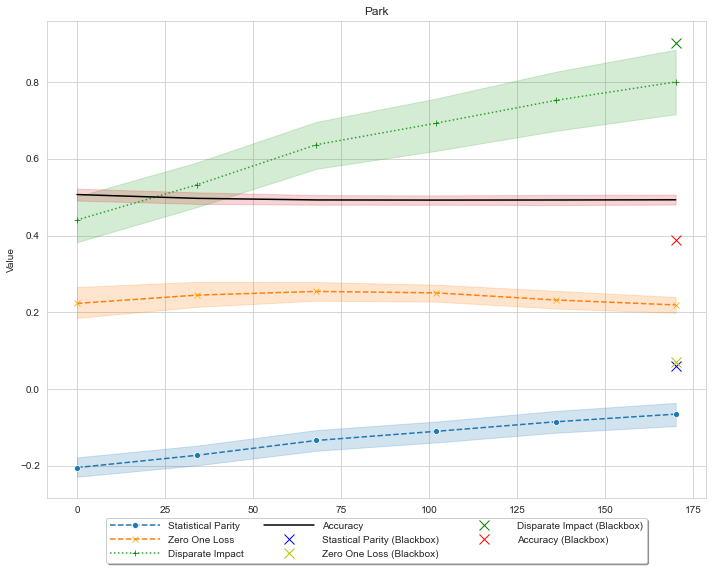

In [37]:
plot_metrics_curves(df, points, 'Park')

In [38]:
unprivpergentage(data, protected_group, 89)

Dataset size: 5875
Unprivileged group size: 2318
Percentage of unprivileged group: 39.45531914893617
Number of iterations: 89
